In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf

from darts import TimeSeries
from darts.models import NaiveSeasonal, NaiveDrift, ExponentialSmoothing, ARIMA, AutoARIMA, Prophet, RNNModel, XGBModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.statistics import check_seasonality
from darts.metrics import mape

In [2]:
df = pd.read_csv("train.csv")
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)

print(df.head(10))
print(df.info())

            store  item  sales
date                          
2013-01-01      1     1     13
2013-01-02      1     1     11
2013-01-03      1     1     14
2013-01-04      1     1     13
2013-01-05      1     1     10
2013-01-06      1     1     12
2013-01-07      1     1     10
2013-01-08      1     1      9
2013-01-09      1     1     12
2013-01-10      1     1      9
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB
None


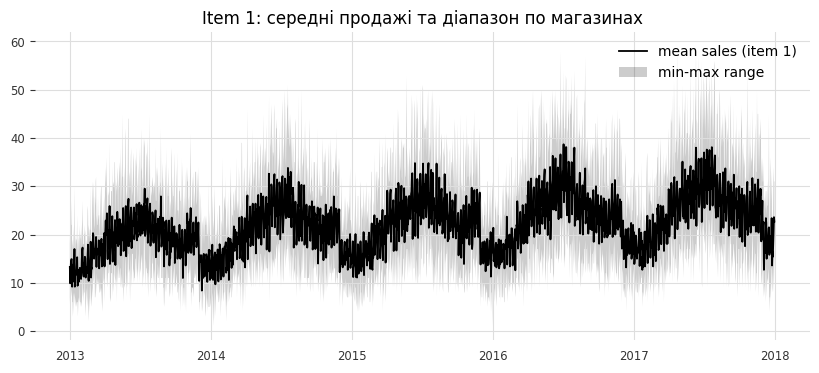

In [3]:
# dynamics for one item

item1_stats = df[df["item"] == 1].groupby("date")["sales"].agg(['mean','min','max'])
plt.figure(figsize=(10,4))
plt.plot(item1_stats.index, item1_stats['mean'], label="mean sales (item 1)")
plt.fill_between(item1_stats.index, item1_stats['min'], item1_stats['max'], alpha=0.2, label="min-max range")
plt.title("Item 1: average sales and range across stores")
plt.legend(); 

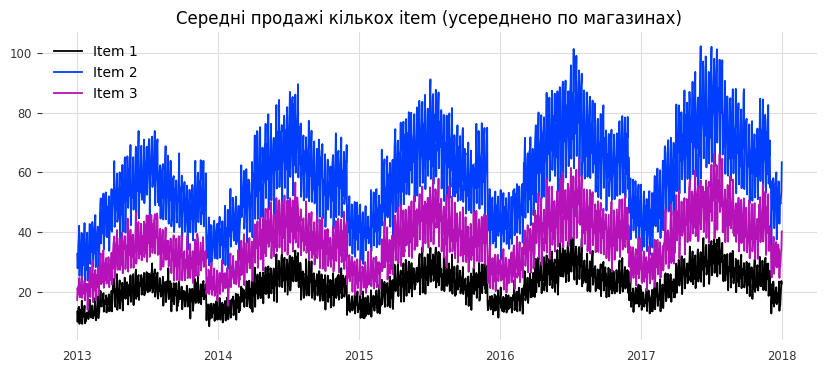

In [4]:
# comparison of multiple items

items_to_plot = [1, 2, 3]
plt.figure(figsize=(10,4))
for item in items_to_plot:
    tmp = df[df["item"] == item].groupby("date")["sales"].mean()
    plt.plot(tmp.index, tmp.values, label=f"Item {item}")
plt.title("Average Sales of Multiple Items (averaged across stores)")
plt.legend(); 

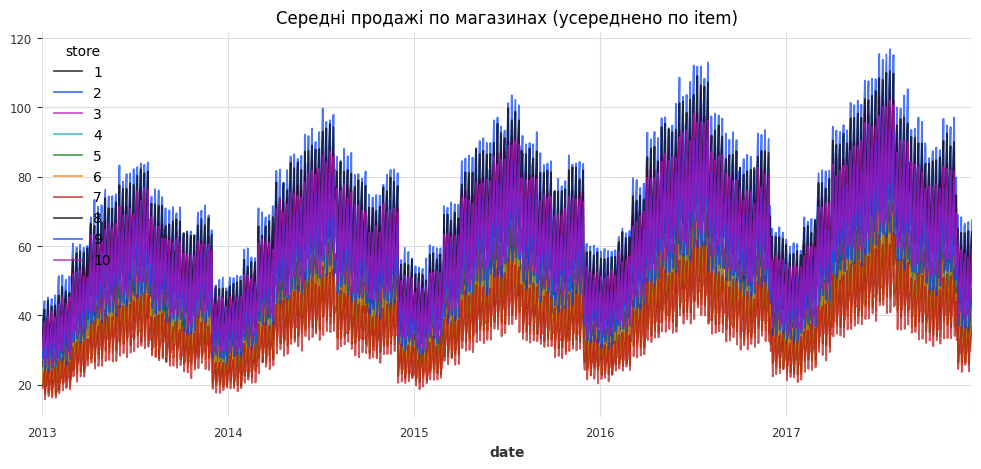

In [5]:
# comparison of stores

stores_mean = df.groupby(["date","store"])["sales"].mean().unstack()
stores_mean.plot(figsize=(12,5), alpha=0.7)
plt.title("Average Sales per Store (averaged across items)")
plt.show()

**We can clearly observe seasonality, as peaks repeat each year. The range shows that different stores may vary significantly in their sales levels, although the overall trend is the same across all of them.**

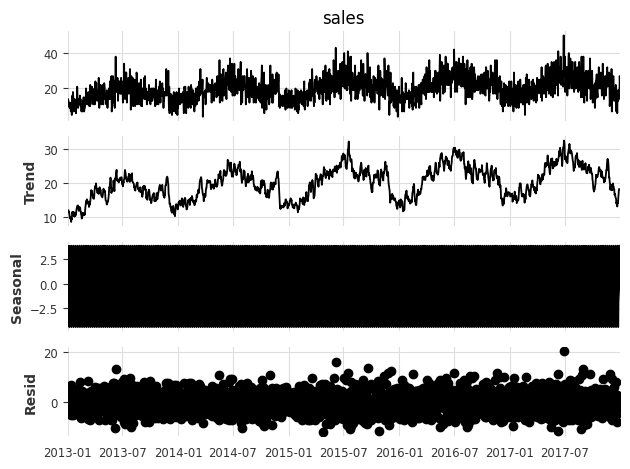

In [6]:
sub_df = df[(df["store"]==1) & (df["item"]==1)]
result = seasonal_decompose(sub_df["sales"], model="additive")
result.plot(); 

**Overall sales show a steady increase from 2013 to 2017, indicating a gradual rise in demand with short-term fluctuations. The seasonality plot appears very dense due to the daily frequency, making yearly or monthly patterns difficult to detect and interpret. The residuals are tightly clustered, with occasional large deviations. To better understand the visualizations, the daily series could be aggregated to weekly or monthly data to make seasonality more apparent, while applying a logarithmic transformation would reduce the impact of sharp peaks.**

In [7]:
series = TimeSeries.from_dataframe(sub_df, value_cols="sales")

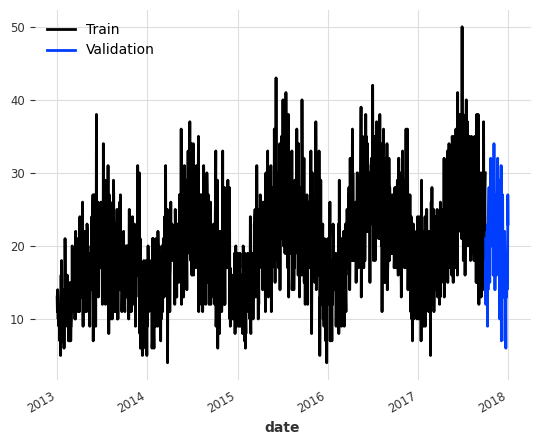

In [8]:
train, val = series.split_before(pd.Timestamp("2017-10-01"))
train.plot(label="Train")
val.plot(label="Validation")
plt.legend(); 

<Figure size 1000x600 with 0 Axes>

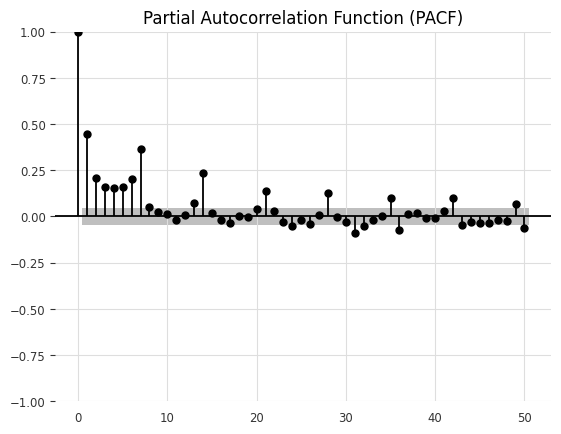

In [9]:
plt.figure(figsize=(10, 6))
plot_pacf(sub_df["sales"], lags=50, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

**For forecasting, it is advisable to use short lags (1–5 days), a weekly lag (7 days), and multiples of 7 (14, 21, 28) if we want to model longer-term seasonality.**

In [10]:
is_seasonal, period = check_seasonality(train, max_lag=400)
print("Seasonal:", is_seasonal, "Period:", period)

Seasonal: True Period: 7


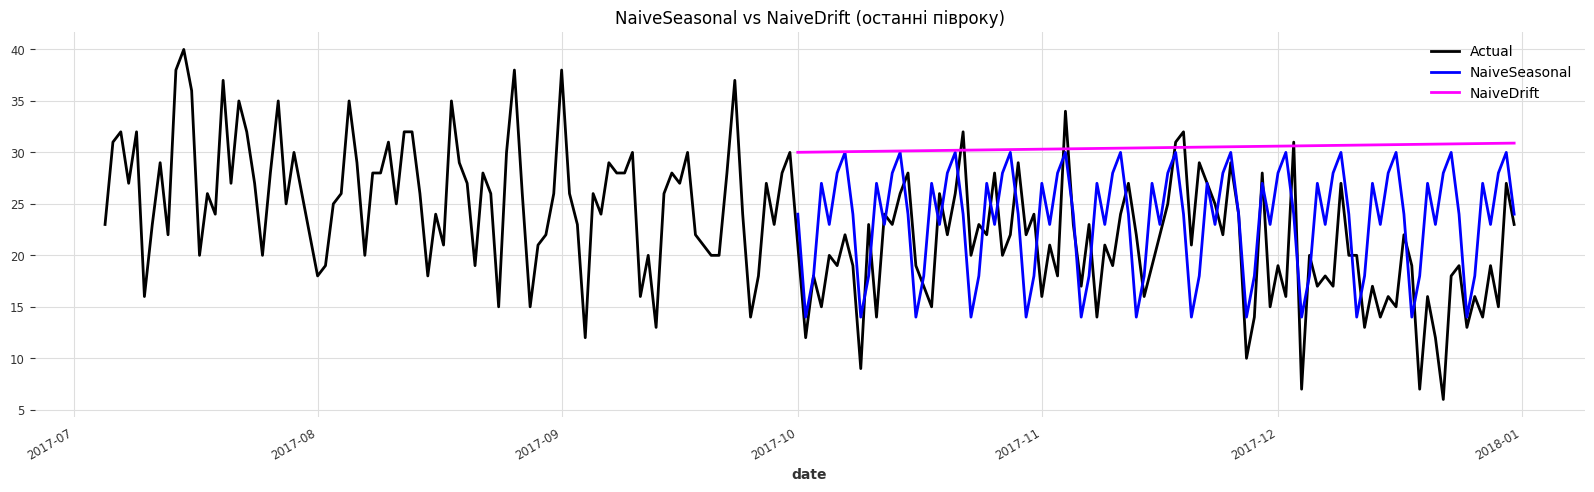

In [11]:
model_ns = NaiveSeasonal(K=7)
model_nd = NaiveDrift()
model_ns.fit(train)
model_nd.fit(train)

pred_ns = model_ns.predict(len(val))
pred_nd = model_nd.predict(len(val))

plt.figure(figsize=(20,5))

series[-180:].plot(label="Actual", lw=2, color="black")
pred_ns.plot(label="NaiveSeasonal", lw=2, color="blue")
pred_nd.plot(label="NaiveDrift", lw=2, color="magenta")

plt.title("NaiveSeasonal vs NaiveDrift (over the last six months)")
plt.legend()
plt.show()

**Regarding NaiveSeasonal, the model only captures an approximate weekly pattern. NaiveDrift performs worse because the trend in the data is unstable, and simple linear extrapolation does not work well.**

In [12]:
print("MAPE NaiveSeasonal:", mape(val, pred_ns))
print("MAPE NaiveDrift:", mape(val, pred_nd))

MAPE NaiveSeasonal: 38.174845664426456
MAPE NaiveDrift: 68.74405050496789


MAPE XGB: 27.633467988404266


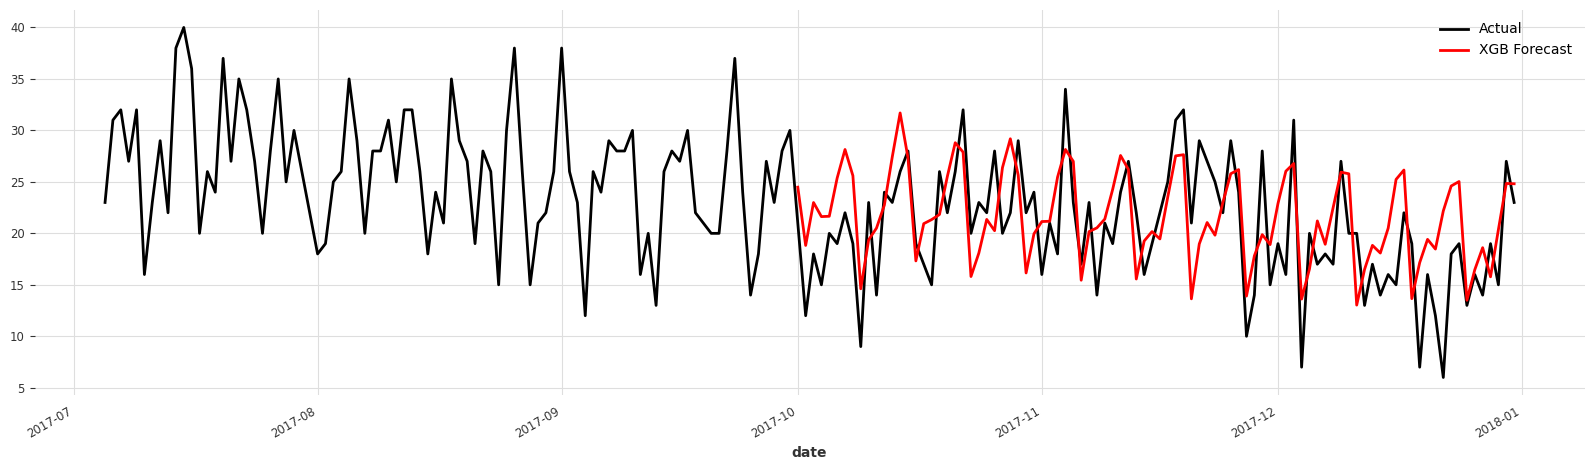

In [13]:
def enrich_with_date_features(df):
    df = df.copy()
    df["quarter"] = df.index.quarter
    df["year"] = df.index.year
    df["dayofyear"] = df.index.dayofyear
    df["month"] = df.index.month
    df["sin_day"] = np.sin(2 * np.pi * df["dayofyear"] / 365)
    df["cos_day"] = np.cos(2 * np.pi * df["dayofyear"] / 365)
    return df

train_df = enrich_with_date_features(train.to_dataframe())
val_df   = enrich_with_date_features(val.to_dataframe())

scaler = Scaler()
train_scaled = scaler.fit_transform(train)
val_scaled   = scaler.transform(val)

model_xgb = XGBModel(
    lags=40,                 
    output_chunk_length=1,   
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


model_xgb.fit(train_scaled)

forecast_scaled = model_xgb.predict(len(val_scaled))
forecast = scaler.inverse_transform(forecast_scaled)

plt.figure(figsize=(20,5))
series[-180:].plot(label="Actual", lw=2, color="black")
forecast.plot(label="XGB Forecast", lw=2, color="red")
plt.legend()

print("MAPE XGB:", mape(val, forecast))

**Although the XGB forecast is not perfect (it fails to capture sharp peaks), it already reproduces the fluctuations much more effectively.**

In [14]:
def plot_forecast(series, forecast, days_back=180):
    plt.figure(figsize=(20,5))
    series[-days_back:].plot(label="Actual", lw=2, color="black")
    forecast.plot(label="Forecast", lw=2, color="red")
    plt.legend();

MAPE ExponentialSmoothing: 39.007846022947


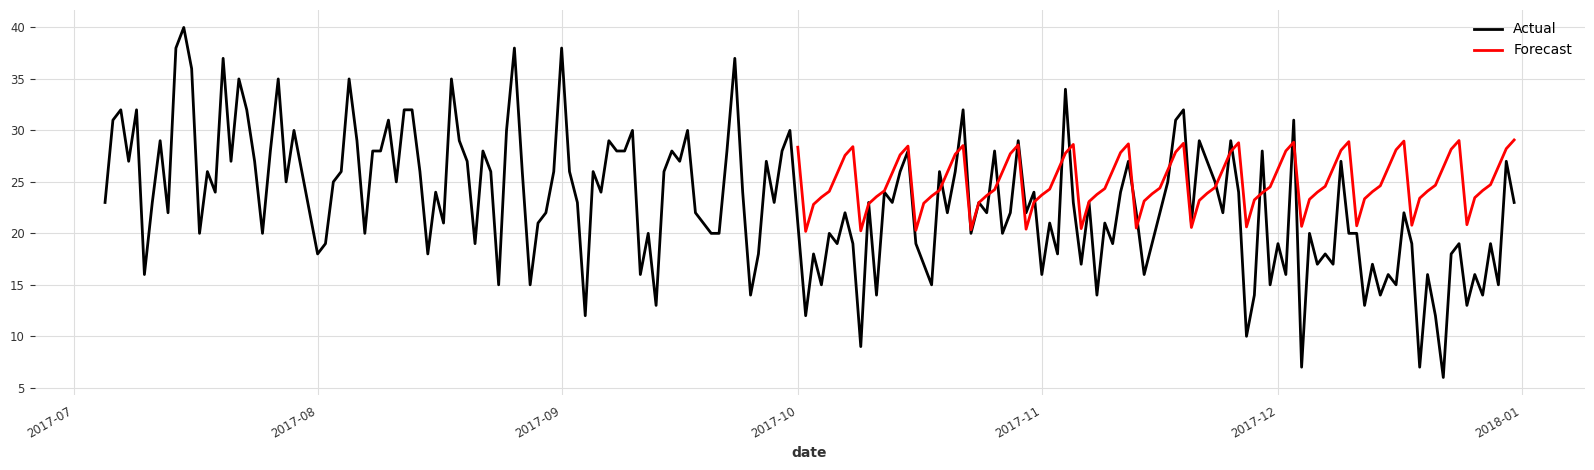

In [15]:
model_es = ExponentialSmoothing()
model_es.fit(train)
pred_es = model_es.predict(len(val))
print("MAPE ExponentialSmoothing:", mape(val, pred_es))

plot_forecast(series, pred_es)

**The plot shows that the model smooths out peaks and captures the overall sales level but fails to follow sharp fluctuations. The forecast appears more stable than the actual data. ExponentialSmoothing performs well when the series has a clear seasonality and trend, but in this case the data is too variable.**

/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MAPE ARIMA: 39.528822828682586


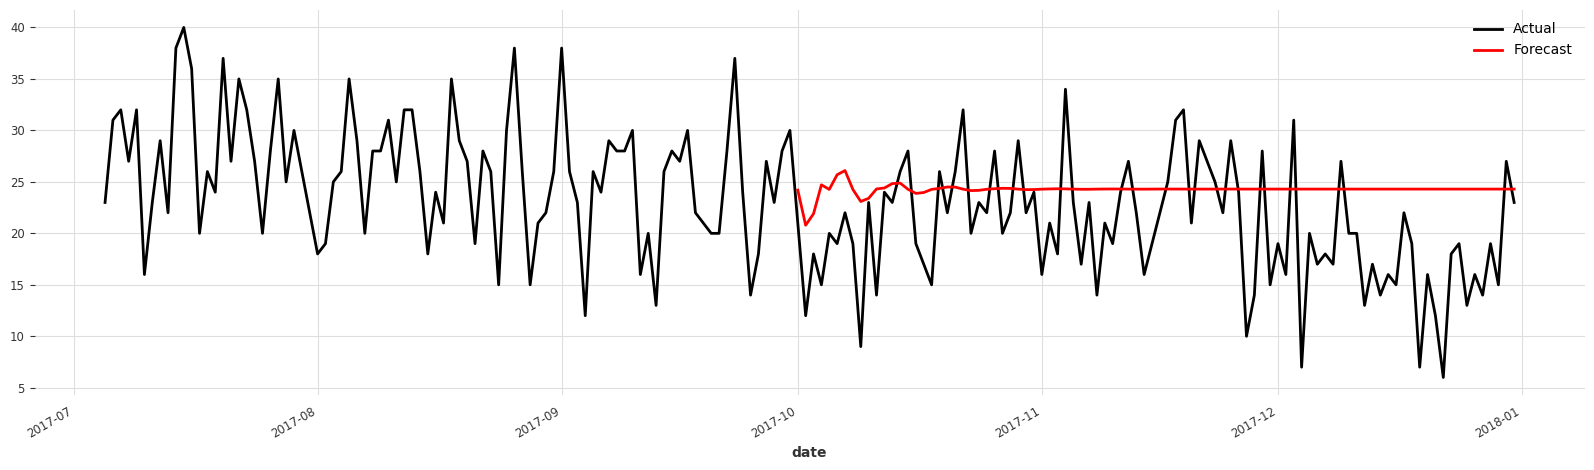

In [16]:
model_arima = ARIMA(p=7, d=1, q=1)
model_arima.fit(train)
pred_arima = model_arima.predict(len(val))
print("MAPE ARIMA:", mape(val, pred_arima))

plot_forecast(series, pred_arima)

**ARIMA(7,1,1) did not show a significant improvement compared to ExponentialSmoothing. This is typical for ARIMA when seasonality is not taken into account.**

MAPE AutoARIMA: 39.49111657306662


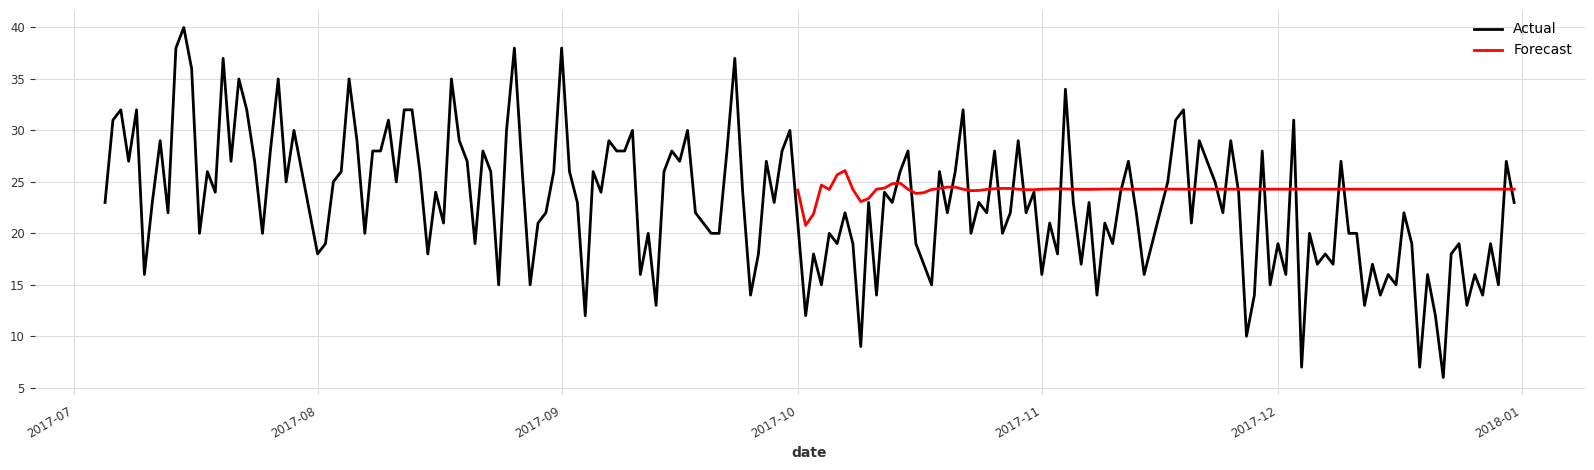

In [17]:
model_auto = AutoARIMA(start_p=7, max_p=32, start_q=1)
model_auto.fit(train)
pred_auto = model_auto.predict(len(val))
print("MAPE AutoARIMA:", mape(val, pred_auto))

plot_forecast(series, pred_auto)

**The quality improved, but only slightly compared to ARIMA.**

22:22:32 - cmdstanpy - INFO - Chain [1] start processing
22:22:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE Prophet: 23.806411778894216


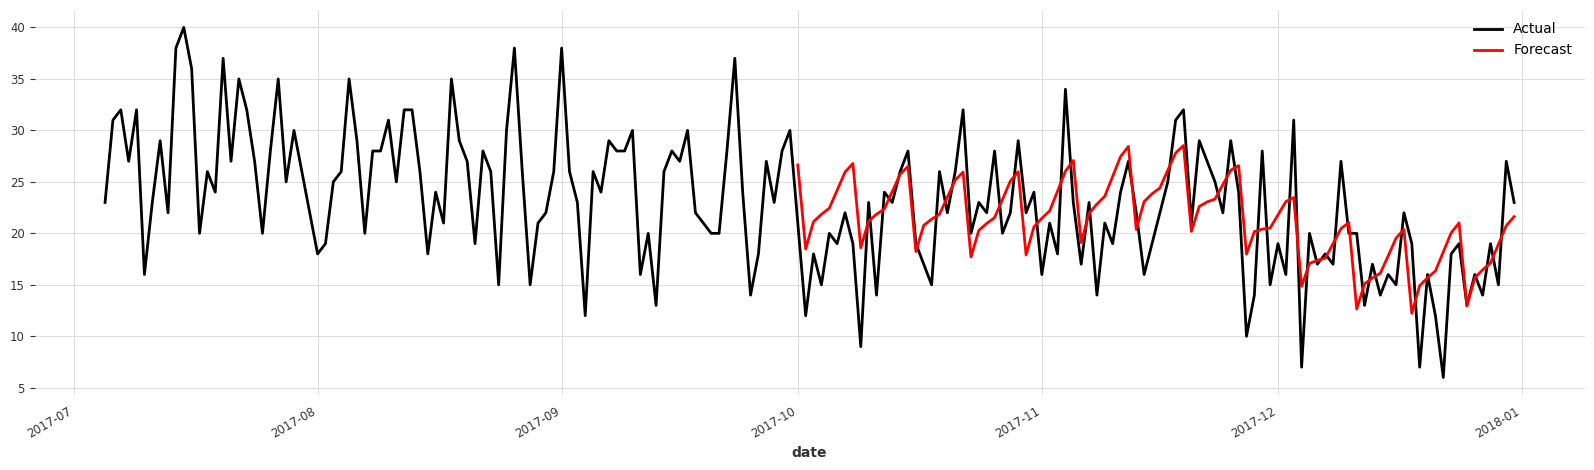

In [18]:
model_prophet = Prophet()
model_prophet.fit(train)
pred_prophet = model_prophet.predict(len(val))
print("MAPE Prophet:", mape(val, pred_prophet))

plot_forecast(series, pred_prophet)

**Prophet turned out to be one of the best models so far. It captures trend and seasonality well, which makes its performance significantly better than classical ARIMA and Exponential Smoothing.**

In [19]:
train_rnn = train.astype(np.float32)
val_rnn   = val.astype(np.float32)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
/Users/sofiapetrova/anaconda3/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory

Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

MAPE RNN: 28.465466


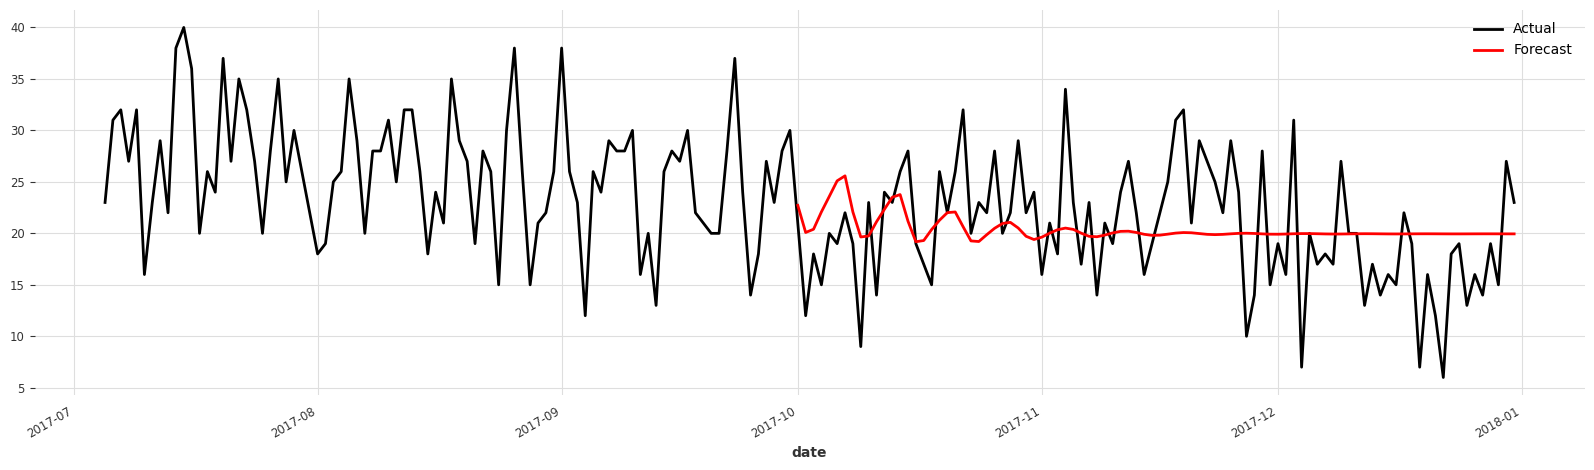

In [23]:
model_rnn = RNNModel(model="LSTM", input_chunk_length=14, n_epochs=150)
model_rnn.fit(train_rnn)
pred_rnn = model_rnn.predict(len(val_rnn))
print("MAPE RNN:", mape(val_rnn, pred_rnn))

plot_forecast(series, pred_rnn)

**Prophet remains the best-performing model, while RNN looks promising but requires longer training.**

historical forecasts:   0%|          | 0/12 [00:00<?, ?it/s]

22:23:23 - cmdstanpy - INFO - Chain [1] start processing
22:23:23 - cmdstanpy - INFO - Chain [1] done processing
22:23:23 - cmdstanpy - INFO - Chain [1] start processing
22:23:24 - cmdstanpy - INFO - Chain [1] done processing
22:23:24 - cmdstanpy - INFO - Chain [1] start processing
22:23:24 - cmdstanpy - INFO - Chain [1] done processing
22:23:24 - cmdstanpy - INFO - Chain [1] start processing
22:23:24 - cmdstanpy - INFO - Chain [1] done processing
22:23:24 - cmdstanpy - INFO - Chain [1] start processing
22:23:24 - cmdstanpy - INFO - Chain [1] done processing
22:23:24 - cmdstanpy - INFO - Chain [1] start processing
22:23:24 - cmdstanpy - INFO - Chain [1] done processing
22:23:24 - cmdstanpy - INFO - Chain [1] start processing
22:23:24 - cmdstanpy - INFO - Chain [1] done processing
22:23:24 - cmdstanpy - INFO - Chain [1] start processing
22:23:24 - cmdstanpy - INFO - Chain [1] done processing
22:23:24 - cmdstanpy - INFO - Chain [1] start processing
22:23:24 - cmdstanpy - INFO - Chain [1]

MAPE Prophet Backtest: 24.518479135134204


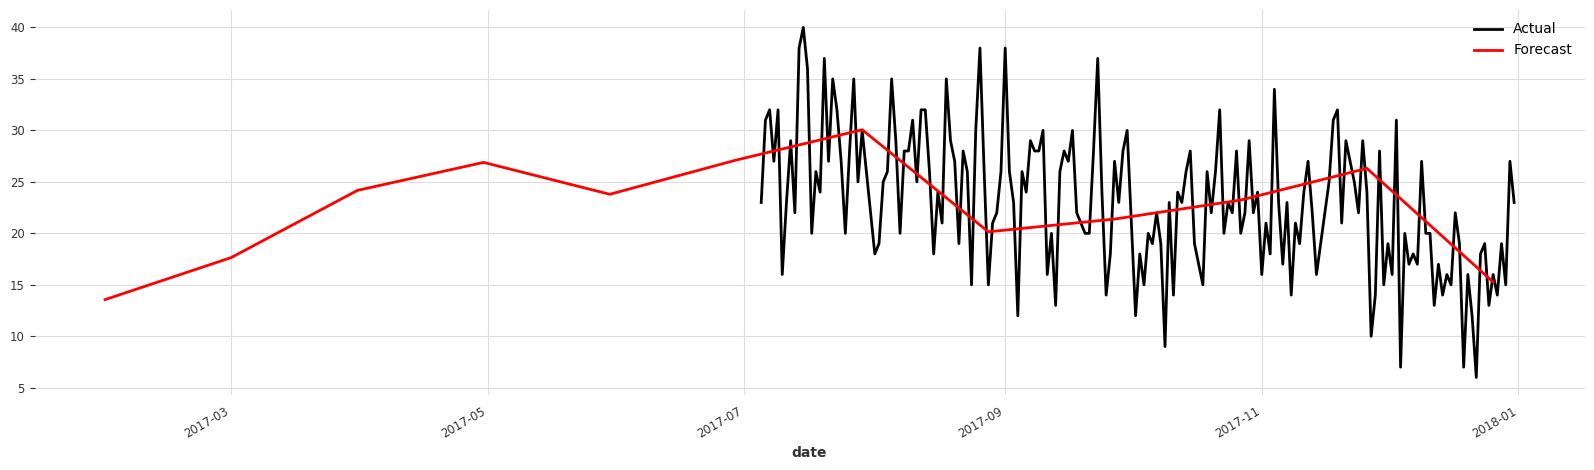

In [21]:
backtest = model_prophet.historical_forecasts(
    series,
    start=pd.Timestamp("2017-01-01"),
    forecast_horizon=30,
    stride=30,
    retrain=True,
    verbose=True
)

print("MAPE Prophet Backtest:", mape(series.slice(pd.Timestamp("2017-01-01"), pd.Timestamp("2017-12-31")), backtest))

plot_forecast(series, backtest)

**The model is stable, as backtest performance closely matches validation performance. The plot shows that Prophet reproduces the average level and seasonality quite well, but fails to capture sharp spikes.**

**Although Prophet achieved the best performance, it does not scale well across all series, since forecasting 50 items in 10 stores would require training 500 separate models. For a real-world forecasting task with 500 time series, it is more practical to apply a global model that is trained on all series simultaneously and shares information between them. An XGBModel with calendar features and lags is a good candidate for this role. This approach allows us to rely on a single model instead of hundreds, obtain faster results, and better capture shared seasonal and trend patterns.**